데이터 준비

In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Data Preprocessing

In [ ]:

print("Original y values:", y['Diagnosis'].unique())

# y 타겟을 {-1, +1}로 변환
# 'M' (Malignant, 악성)을 -1로, 'B' (Benign, 양성)을 +1로 매핑.
y = y['Diagnosis'].map({'M': -1, 'B': 1}).values

# X, y를 pandas DataFrame에서 NumPy 배열로 변환
X = X.values

print(f"Data shapes: X={X.shape}, y={y.shape}")
print("Converted y values:", np.unique(y))

Original y values: ['M' 'B']
Data shapes: X=(569, 30), y=(569,)
Converted y values: [-1  1]


Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (398, 30), Test set: (171, 30)


Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Scratch Implementation

In [ ]:
class MyAdaBoost:

    def __init__(self, n_estimators=50, max_depth=1):
        self.n_estimators = n_estimators # T: 반복 횟수
        self.max_depth = max_depth       # 약한 학습기의 복잡도
        self.estimators_ = [] # 약한 학습기 h_t 저장
        self.alphas_ = []     # 분류기 계수 alpha_t 저장

    def fit(self, X, y):
        n_samples = X.shape[0]

        # 1. 샘플 가중치 초기화: w = 1/N [cite: 257]
        w = np.full(n_samples, (1 / n_samples))

        self.estimators_ = []
        self.alphas_ = []

        for t in range(self.n_estimators):
            # 2. 가중 훈련 데이터에 약한 학습기 h_t 적합 [cite: 259]
            estimator = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)

            # scikit-learn의 sample_weight 인자를 활용
            estimator.fit(X, y, sample_weight=w)
            y_pred_t = estimator.predict(X)

            # 3. 가중 오류 err_t 계산 [cite: 260, 262]
            # I(h(x) != t) 계산
            incorrect = (y_pred_t != y)

            # err_t = sum(w_i * I(h_i != t_i)) / sum(w_i)
            err_t = np.sum(w[incorrect]) / np.sum(w)

            # 0으로 나누기 오류나 log(0) 오류를 피하기 위한 클리핑
            err_t = np.clip(err_t, 1e-10, 1 - 1e-10)

            # 4. 분류기 계수 alpha_t 계산 [cite: 263, 264]
            # alpha_t = 1/2 * log((1 - err_t) / err_t)
            alpha_t = 0.5 * np.log((1.0 - err_t) / err_t)

            # 5. 데이터 가중치 w 업데이트 [cite: 265, 266]
            # w = w * exp(-alpha_t * y * h_t(x))
            w *= np.exp(-alpha_t * y * y_pred_t)

            # 가중치 정규화 (다음 반복을 위해)
            w /= np.sum(w)

            # 훈련된 모델과 계수 저장
            self.estimators_.append(estimator)
            self.alphas_.append(alpha_t)

    def predict(self, X):

        # 각 약한 학습기 h_t(x)의 예측값 계산
        estimator_preds = np.array([clf.predict(X) for clf in self.estimators_])

        # alpha_t 가중합 (sum(alpha_t * h_t(x)))
        weighted_preds = np.dot(self.alphas_, estimator_preds)

        # 최종 부호(sign) 반환
        return np.sign(weighted_preds)

    def staged_score(self, X, y):

        scores = []
        current_pred_sum = np.zeros(X.shape[0])

        for alpha, clf in zip(self.alphas_, self.estimators_):
            # H_m(x) = H_{m-1}(x) + alpha_m * h_m(x) [cite: 371]
            current_pred_sum += alpha * clf.predict(X)

            # m번째 모델까지의 예측 [cite: 269]
            y_pred_m = np.sign(current_pred_sum)

            # 정확도 계산 및 저장
            score = accuracy_score(y, y_pred_m)
            scores.append(score)

        return scores


모델 훈련 및 테스트 정확도 관찰

Starting model training...
Model training complete.
Calculating staged test scores...
Final test accuracy with 100 stumps: 0.9708


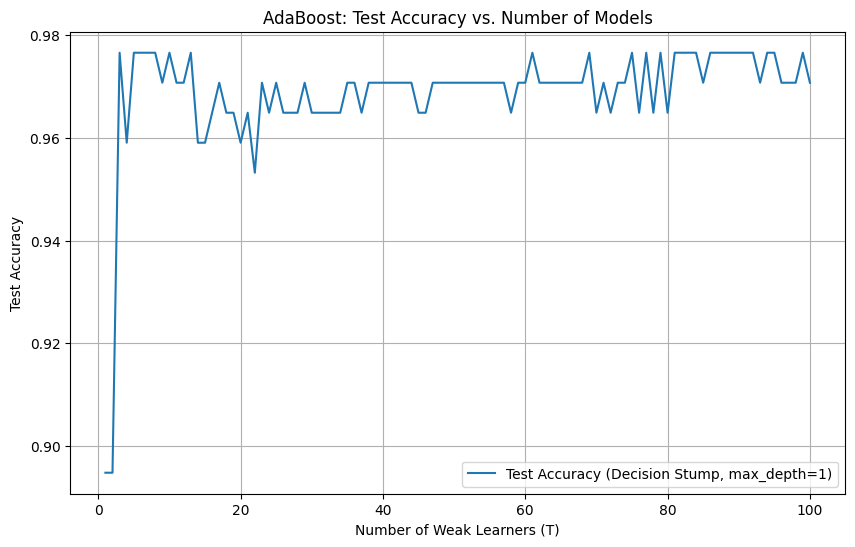

In [ ]:
# T=100
n_estimators_total = 100
model_stump = MyAdaBoost(n_estimators=n_estimators_total, max_depth=1)

# 1.fit
print("Starting model training...")
model_stump.fit(X_train, y_train)
print("Model training complete.")

# 2.staged_score

print("Calculating staged test scores...")
test_scores_stump = model_stump.staged_score(X_test, y_test)

print(f"Final test accuracy with {n_estimators_total} stumps: {test_scores_stump[-1]:.4f}")

# 3. Visualize results
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators_total + 1), test_scores_stump, label='Test Accuracy (Decision Stump, max_depth=1)')
plt.xlabel('Number of Weak Learners (T)')
plt.ylabel('Test Accuracy')
plt.title('AdaBoost: Test Accuracy vs. Number of Models')
plt.legend()
plt.grid(True)
plt.show()

Additional Experiments : Comparing Weak Learner Complexity

Training complex model (max_depth=3)...
Complex model training complete.
Final test accuracy with 100 trees (max_depth=3): 0.9766


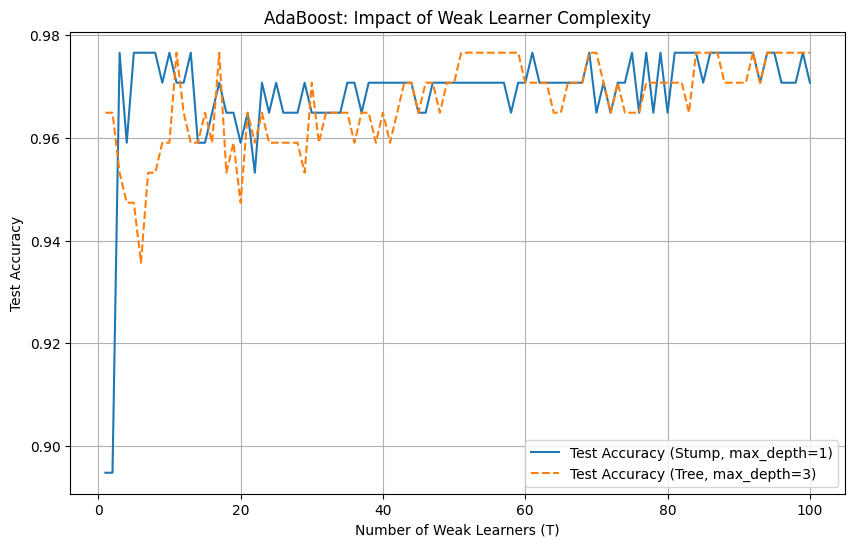

In [ ]:

# T=100, max_depth=3
model_tree = MyAdaBoost(n_estimators=n_estimators_total, max_depth=3)


print("Training complex model (max_depth=3)...")
model_tree.fit(X_train, y_train)
print("Complex model training complete.")


test_scores_tree = model_tree.staged_score(X_test, y_test)

print(f"Final test accuracy with {n_estimators_total} trees (max_depth=3): {test_scores_tree[-1]:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators_total + 1), test_scores_stump, label='Test Accuracy (Stump, max_depth=1)')
plt.plot(range(1, n_estimators_total + 1), test_scores_tree, label='Test Accuracy (Tree, max_depth=3)', linestyle='--')
plt.xlabel('Number of Weak Learners (T)')
plt.ylabel('Test Accuracy')
plt.title('AdaBoost: Impact of Weak Learner Complexity')
plt.legend()
plt.grid(True)
plt.show()